In [1]:
import nbformat

notebook_path = 'Twitter_sentiment_analysis.ipynb'
nb = nbformat.read(notebook_path, as_version=4)

if 'widgets' in nb.metadata:
    del nb.metadata['widgets']

nbformat.write(nb, notebook_path)
print("Removed widget metadata.")


Removed widget metadata.


In [1]:
# Install Kaggle API
!pip install kaggle

# Upload kaggle.json (your Kaggle API credentials)
from google.colab import files
files.upload()

# Move kaggle.json to the appropriate directory
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d jp797498e/twitter-entity-sentiment-analysis

# Unzip the dataset
!unzip twitter-entity-sentiment-analysis.zip


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis
License(s): CC0-1.0
  0% 0.00/1.99M [00:00<?, ?B/s]
100% 1.99M/1.99M [00:00<00:00, 357MB/s]
Archive:  twitter-entity-sentiment-analysis.zip
  inflating: twitter_training.csv    
  inflating: twitter_validation.csv  


In [2]:
import pandas as pd

# Load the dataset
df = pd.read_csv('twitter_training.csv', header=None)
df.columns = ['Tweet_ID', 'Topic', 'Sentiment', 'Tweet']

# Display basic information
print("Dataset Shape:", df.shape)
print("Sentiment Distribution:\n", df['Sentiment'].value_counts())
df.head()


Dataset Shape: (74682, 4)
Sentiment Distribution:
 Sentiment
Negative      22542
Positive      20832
Neutral       18318
Irrelevant    12990
Name: count, dtype: int64


,Tweet_ID,Topic,Sentiment,Tweet
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [3]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    if pd.isnull(text):  # check for NaN
        return ''
    text = str(text)  # ensure text is a string
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'#\w+', '', text)  # Remove hashtags
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^A-Za-z\s]', '', text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Now apply the cleaning safely
df['Clean_Tweet'] = df['Tweet'].apply(clean_text)



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


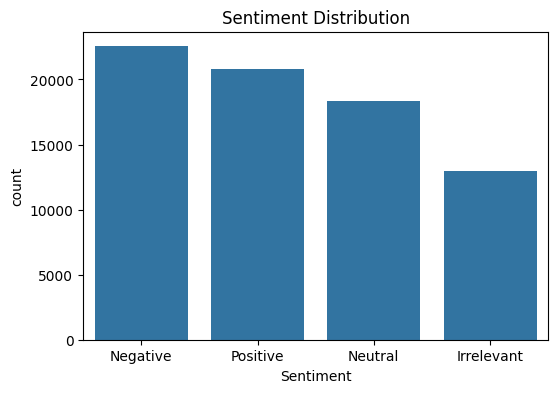

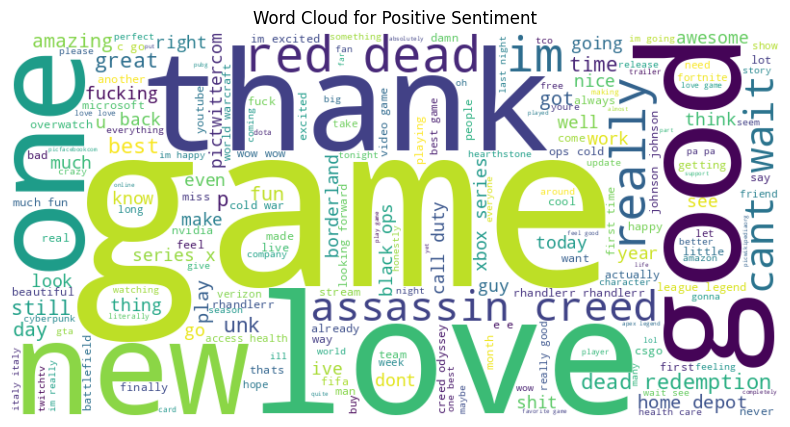

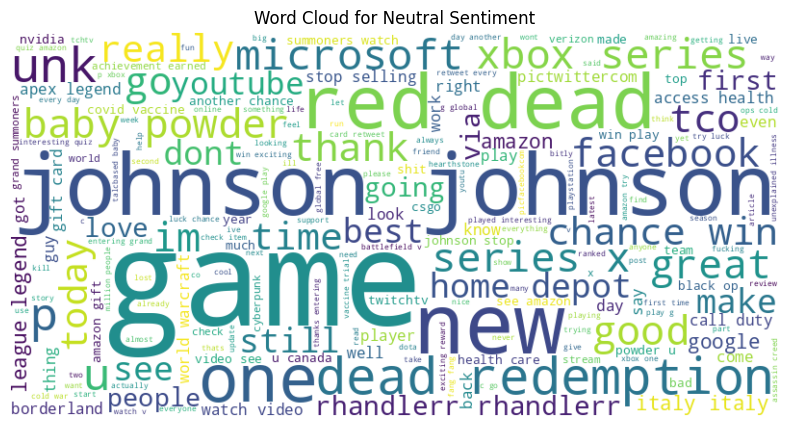

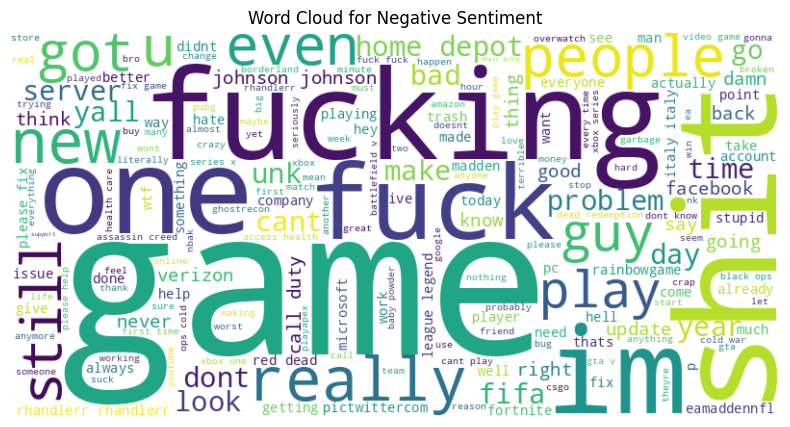

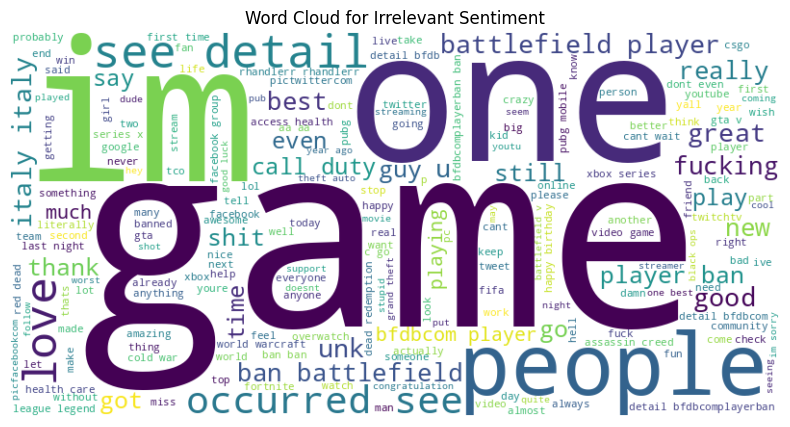

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Sentiment distribution
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Sentiment', order=df['Sentiment'].value_counts().index)
plt.title('Sentiment Distribution')
plt.show()

# Word clouds for each sentiment
for sentiment in df['Sentiment'].unique():
    text = ' '.join(df[df['Sentiment'] == sentiment]['Clean_Tweet'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {sentiment} Sentiment')
    plt.show()


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['Clean_Tweet']).toarray()
y = df['Sentiment']


In [6]:
!pip install transformers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf
import numpy as np

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(df['Clean_Tweet'], y_encoded, test_size=0.2, random_state=42)

# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize and encode sequences
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=128)

# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
)).batch(16)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
)).batch(16)

# Initialize BERT model
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(le.classes_))

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the model
model.fit(train_dataset, epochs=3, validation_data=test_dataset)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
3735/3735 [==============================] - 1694s 438ms/step - loss: 0.9132 - accuracy: 0.6289 - val_loss: 0.6103 - val_accuracy: 0.7670
Epoch 2/3
3735/3735 [==============================] - 1624s 435ms/step - loss: 0.4158 - accuracy: 0.8435 - val_loss: 0.4302 - val_accuracy: 0.8519
Epoch 3/3
3735/3735 [==============================] - 1630s 436ms/step - loss: 0.2180 - accuracy: 0.9169 - val_loss: 0.3661 - val_accuracy: 0.8765


In [7]:
# Evaluate the model
loss, accuracy = model.evaluate(test_dataset)
print(f'Accuracy: {accuracy:.4f}')

# Generate classification report
from sklearn.metrics import classification_report

# Predict on test data
y_pred_probs = model.predict(test_dataset).logits
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))


934/934 [==============================] - 147s 157ms/step - loss: 0.3661 - accuracy: 0.8765
Accuracy: 0.8765
934/934 [==============================] - 140s 145ms/step
Classification Report:
              precision    recall  f1-score   support

  Irrelevant       0.89      0.84      0.86      2592
    Negative       0.91      0.89      0.90      4519
     Neutral       0.86      0.88      0.87      3596
    Positive       0.84      0.88      0.86      4230

    accuracy                           0.88     14937
   macro avg       0.88      0.87      0.87     14937
weighted avg       0.88      0.88      0.88     14937



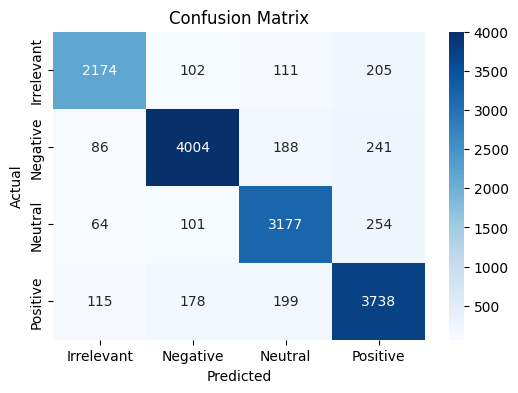

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('Confusion_matrix_twitter.png')
plt.show()
